In [1]:
from IPython.display import clear_output

In [2]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-geometric==2.3.1
# !pip install torch-geometric-temporal
# clear_output()

In [3]:
import os
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

clear_output()

In [4]:
def load_features(feat_path, dtype=np.float32):
    feat_df = pd.read_csv(feat_path)
    feat = np.array(feat_df, dtype=dtype)
    return feat


def load_adjacency_matrix(adj_path, dtype=np.float32):
    adj_df = pd.read_csv(adj_path, header=None)
    adj = np.array(adj_df, dtype=dtype)
    return adj

### Определение гиперпараметров

In [5]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
# feat_path = f"{data_path}/speed.csv"
# adj_path = f"{data_path}/adj.csv"

# Для данных microservices
adj_type = "bad"
service = "no"
type_data = "duration"
feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

seq_len = 12
pre_len = 3

### Подготовка данных

In [6]:
def train_test_split(data, split_ratio=0.8):
    data_len = data.shape[0]
    train_size = int(data_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def xy_split(data: np.ndarray, seq_len: int = 12, pre_len: int = 3):
    X_data, Y_data = [], []
    
    for i in range(data.shape[0] - int(seq_len + pre_len - 1)):
        a = data[i:i + seq_len + pre_len]
        X_data.append(a[:seq_len])
        Y_data.append(a[seq_len:seq_len + pre_len])

    return np.array(X_data).transpose((0, 2, 1)), np.array(Y_data).transpose((0, 2, 1))


def normalize_data(data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    normalized_data = (data - means) / stds
    return np.nan_to_num(normalized_data, 0)


def denormalize_data(normalized_data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    return normalized_data * stds + means        

In [7]:
# train_data, test_data = train_test_split(data=feat)
# means = train_data.mean(axis=0)
# stds = train_data.std(axis=0)

# train_data_normalized = normalize_data(train_data, means, stds)
# test_data_normalized = normalize_data(test_data, means, stds)

# X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
# X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)

### Подготовка матрицы смежности

In [8]:
def get_edge_parameters(adj_matrix):
    edges = np.nonzero(adj_matrix)
    edges = np.vstack([edges, adj_matrix[edges]])
    edge_index = edges[:2, :].astype(float)
    edge_attr = edges[2, :].astype(float)
    
    return edge_index, edge_attr

In [9]:
def get_data_loaders(data: np.ndarray, adj_matrix: np.ndarray, seq_len: int, pre_len: int):
    train_data, test_data = train_test_split(data=data)
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    
    train_data_normalized = normalize_data(train_data, means, stds)
    test_data_normalized = normalize_data(test_data, means, stds)

    X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
    X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)
    
    edge_index, edge_attr = get_edge_parameters(adj_matrix)
    
    train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
    test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
    
    return train_loader, test_loader
    

## DCRNN

In [17]:
class DCRNNModel(torch.nn.Module):
    def __init__(self, seq_len, pre_len, hidden_layers=32):
        super(DCRNNModel, self).__init__()
        self.recurrent = DCRNN(seq_len, hidden_layers, 1)
        self.linear = torch.nn.Linear(hidden_layers, pre_len)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [11]:
def evaluate_model(model, data_loader, device):
    loss = 0
    step = 0
    
    with torch.no_grad():
        for snapshot in data_loader:
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss + torch.mean(torch.abs(y_hat - snapshot.y))
            step += 1
        loss = loss / (step + 1)
    
    print("Val loss MAE: {:.4f}".format(loss.item()))
    return loss.item()

### Обучение модели

In [285]:
best_model = None

def train_model(model, train_loader, test_loader, optimizer, epochs, device, pre_len):
    train_losses, val_losses = [], []
    best_val_loss = np.inf

    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        print('==========')
        if (epoch + 1) % 50 == 0:
            optimizer.param_groups[0]['lr'] *= 0.8
            print(f"lr={optimizer.param_groups[0]['lr']}")

        loss = 0
        model.train()

        for time, snapshot in enumerate(train_loader):
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss + torch.mean(torch.abs(y_hat - snapshot.y))
        loss = loss / (time + 1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())
        print("Train loss MAE: {:.4f}".format(loss.item()))

        val_loss = evaluate_model(model, test_loader, device)
        val_losses.append(val_loss)
        
        # path_save = f"../../models/{dataset}/{pre_len}/dcrnn"
        path_save = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/dcrnn"
        if not os.path.exists(path_save):
            os.makedirs(path_save)
        with open(f"{path_save}/losses0.pk", "wb") as f:
            pickle.dump((train_losses, val_losses), f)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), f"{path_save}/best_model0.pt")
            best_val_loss = val_loss
            best_model = model
            print(f"Model with {best_val_loss} was saved.")

    return model, train_losses, val_losses

In [286]:
def main(seq_len, pre_len, model = None):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

    if not model:
        model = DCRNNModel(seq_len, pre_len)
    model.to(device)

    lr = 0.01
    epochs = 200
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model, train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, epochs, device, pre_len)
    
    return model, train_losses, val_losses
    

In [287]:
for pre_len in (3, 6, 12):
# ple_len = 3  
    model, train_losses, val_losses = main(seq_len=12, pre_len=pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Epoch:  1
Train loss MAE: 0.4682
Val loss MAE: 0.6802
Model with 0.6801901459693909 was saved.
Epoch:  2
Train loss MAE: 0.4112
Val loss MAE: 0.6255
Model with 0.625495433807373 was saved.
Epoch:  3
Train loss MAE: 0.3627
Val loss MAE: 0.5741
Model with 0.5741046071052551 was saved.
Epoch:  4
Train loss MAE: 0.3248
Val loss MAE: 0.5212
Model with 0.5212346911430359 was saved.
Epoch:  5
Train loss MAE: 0.2912
Val loss MAE: 0.4788
Model with 0.47879284620285034 was saved.
Epoch:  6
Train loss MAE: 0.2745
Val loss MAE: 0.4550
Model with 0.4549812078475952 was saved.
Epoch:  7
Train loss MAE: 0.2692
Val loss MAE: 0.4440
Model with 0.4440343976020813 was saved.
Epoch:  8
Train loss MAE: 0.2694
Val loss MAE: 0.4425
Model with 0.4424741268157959 was saved.
Epoch:  9
Train loss MAE: 0.2726
Val loss MAE: 0.4416
Model with 0.4416030943393707 was saved.
Epoch:  10
Train loss MAE: 0.2718
Val loss MAE: 0.4388
Model with 0.43880343437194824 was saved.
Epoch:  11
Train loss MAE: 0.2641
Val loss MAE: 

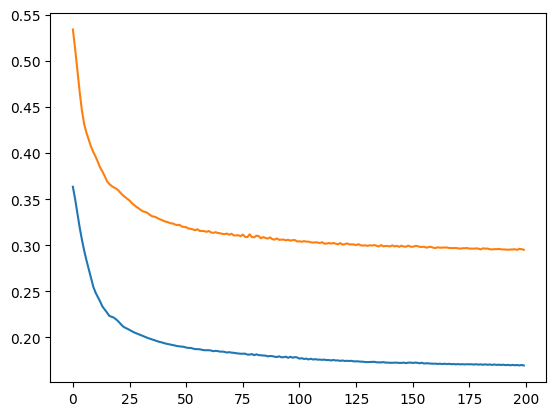

In [270]:
plt.plot(train_losses)
plt.plot(val_losses)

In [271]:
train_data, test_data = train_test_split(data=feat)
means = feat.mean(axis=0)
stds = feat.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

In [272]:
def get_predict_result(model, data_loader, means, stds, result_shape):
    model.eval()
    Y_preds = list()

    for snapshot in data_loader:
        y = snapshot.y.cpu().numpy()
        y_pred = model(
            snapshot.x,
            snapshot.edge_index, 
            snapshot.edge_attr,
        ).view(len(snapshot.x),-1).cpu().detach().numpy()

        y_pred = denormalize_data(y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
        Y_preds.extend(list(y_pred))

    Y_preds = np.array(Y_preds)
    Y_preds = Y_preds.reshape(result_shape)
    return Y_preds

In [273]:
Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_test_ground_truth.shape)
# np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

In [274]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mean_absolute_error(Y_preds.flatten(), Y_test_ground_truth.flatten())

27.47988

In [275]:
r2_score(Y_preds.flatten(), Y_test_ground_truth.flatten())

-13.100640519128413

In [276]:
mean_squared_error(Y_preds.flatten(), Y_test_ground_truth.flatten(), squared=False)

171.60587

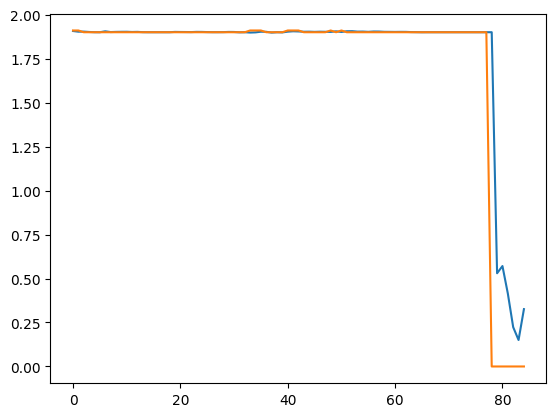

In [277]:
plt.plot(Y_preds[:, 1, 0])
plt.plot(Y_test_ground_truth[:, 1, 0])

In [ ]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "good"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

model_type = "tgcn"
seq_len = 12
pre_len = 3

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

# Генерация данных по предсказаниям

#### metr-la, seoul

In [324]:
dataset = "seoul"
data_path = f"../../data/{dataset}"
feat_path = f"{data_path}/speed.csv"
adj_path = f"{data_path}/adj.csv"
model_type = "dcrnn"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

seq_len = 12
pre_len = 12

model_path = f"../../models/{dataset}/{pre_len}/{model_type}"

In [72]:
def read_model(model_path: str, seq_len, pre_len):
    model = DCRNNModel(seq_len=seq_len, pre_len=pre_len)
    model.load_state_dict(torch.load(f"{model_path}/best_model0.pt"))
    return model

In [25]:
def get_predict_result(model, data_loader, means, stds, result_shape):
    model.eval()
    Y_preds = list()

    for snapshot in data_loader:
        y = snapshot.y.cpu().numpy()
        y_pred = model(
            snapshot.x,
            snapshot.edge_index, 
            snapshot.edge_attr,
        ).view(len(snapshot.x),-1).cpu().detach().numpy()

        y_pred = denormalize_data(y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
        Y_preds.extend(list(y_pred))

    Y_preds = np.array(Y_preds)
    Y_preds = Y_preds.reshape(result_shape)
    return Y_preds

In [327]:
train_data, test_data = train_test_split(data=feat)
means = train_data.mean(axis=0)
stds = train_data.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

In [328]:
save_path = f"../../result_predict/{dataset}/{pre_len}"

np.save(f"{save_path}/ground_truth/test.npy", Y_test_ground_truth)
np.save(f"{save_path}/ground_truth/train.npy", Y_train_ground_truth)

In [329]:
model = read_model(model_path=model_path, seq_len=seq_len, pre_len=pre_len)

In [330]:
Y_preds = get_predict_result(model=model, data_loader=train_loader, means=means, stds=stds, result_shape=Y_train_ground_truth.shape)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

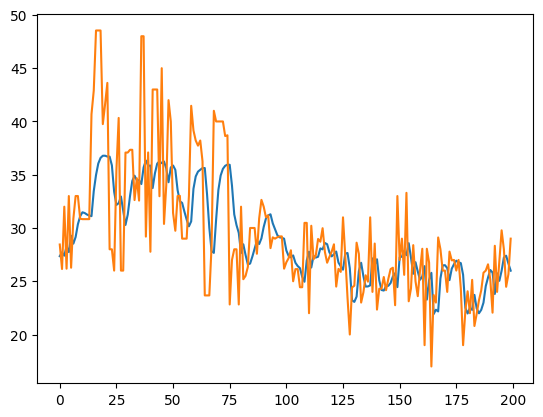

In [331]:
plt.plot(Y_preds[0:200, 100, 0])
plt.plot(Y_train_ground_truth[0:200, 100, 0])

In [332]:
Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_test_ground_truth.shape)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

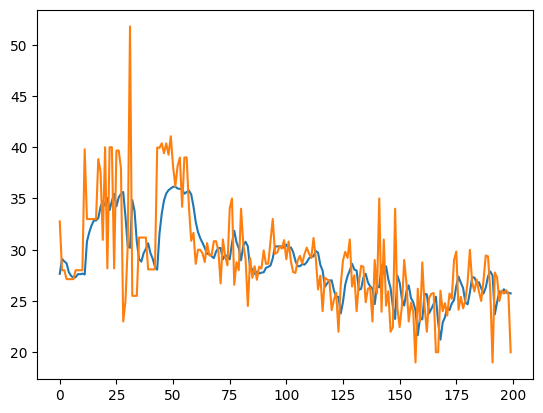

: 

In [333]:
plt.plot(Y_preds[0:200, 100, 0])
plt.plot(Y_test_ground_truth[0:200, 100, 0])

In [115]:
losses = []
path_save = "../../models/microservices/good/no/duration/3/dcrnn"
with (open(f"{path_save}/losses0.pk", "rb")) as openfile:
    while True:
        try:
            losses.append(pickle.load(openfile))
        except EOFError:
            break

train_losses = losses[0][0]
val_losses = losses[0][1]

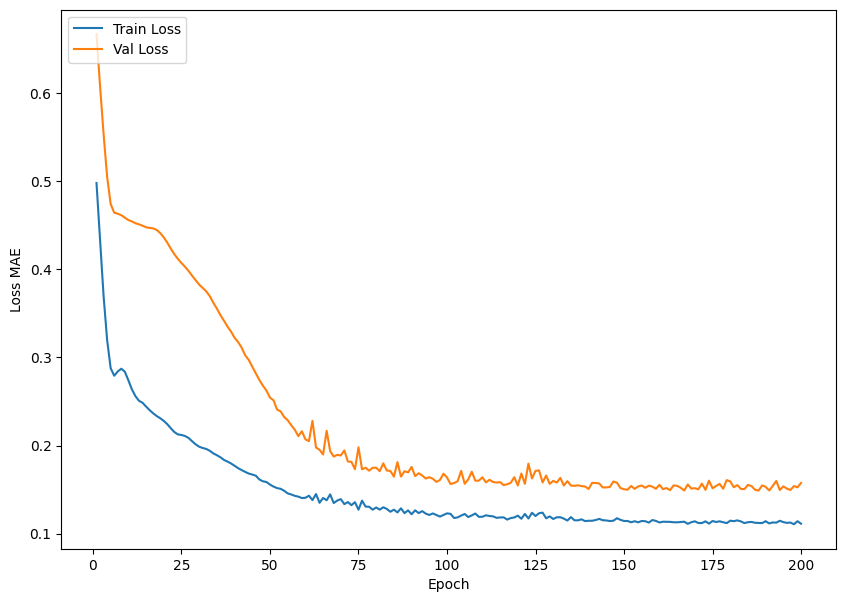

In [116]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend(loc="upper left")
plt.show()

#### microservices

default_data

In [18]:
def read_model(model_path: str, seq_len, pre_len):
    model = DCRNNModel(seq_len=seq_len, pre_len=pre_len, hidden_layers=32)
    model.load_state_dict(torch.load(f"{model_path}/best_model.pt"))
    return model

In [26]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "good"
service = "no"
type_data = "duration"
feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

model_type = "dcrnn"
seq_len = 12
pre_len = 3

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

In [27]:
train_data, test_data = train_test_split(data=feat)
means = feat.mean(axis=0)
stds = feat.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [28]:
save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"

# np.save(f"{save_path}/ground_truth/test.npy", Y_test_ground_truth)
# np.save(f"{save_path}/ground_truth/train.npy", Y_train_ground_truth)

In [29]:
model = read_model(model_path=model_path, seq_len=seq_len, pre_len=pre_len)

In [30]:
Y_preds = get_predict_result(model=model, data_loader=train_loader, means=means, stds=stds, result_shape=Y_train_ground_truth.shape)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

In [31]:
Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_test_ground_truth.shape)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

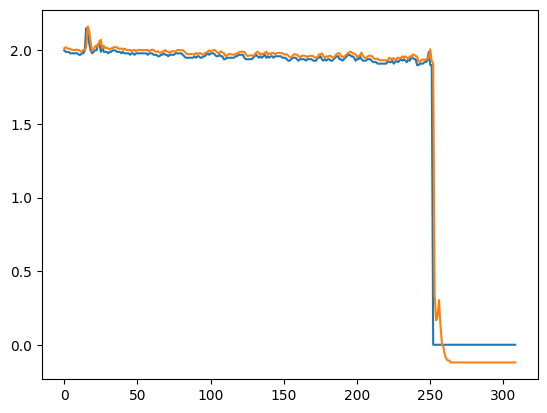

In [32]:
plt.plot(Y_test_ground_truth[:, 1, 0])
plt.plot(Y_preds[:, 1, 0])

fault data

In [33]:
for service in ("cart", "currency", "product"):
    feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
    save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"

    feat = load_features(feat_path)
    adj_matrix = load_adjacency_matrix(adj_path)
    
    _, Y_ground_truth = xy_split(feat, seq_len, pre_len)
    np.save(f"{save_path}/ground_truth/test.npy", Y_ground_truth)
    
    means = feat.mean(axis=0)
    stds = feat.std(axis=0)

    data_normalized = normalize_data(feat, means, stds)
    X_test, Y_test = xy_split(data_normalized, seq_len, pre_len)
    edge_index, edge_attr = get_edge_parameters(adj_matrix)
    test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
    Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_ground_truth.shape)
    np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


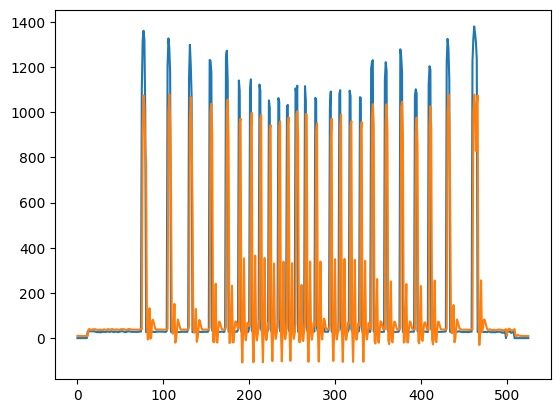

In [34]:
plt.plot(Y_ground_truth[:, 2, 0])
plt.plot(Y_preds[:, 2, 0])

In [257]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [258]:
mean_absolute_error(y_pred=Y_preds.flatten(), y_true=Y_ground_truth.flatten())

62.525818